In [1]:
from collections.abc import Iterable
import os

from datetime import datetime, timedelta
from dateutil import tz
from hdmf.backends.hdf5.h5_utils import H5DataIO
from hdmf.container import Container
from hdmf.data_utils import DataChunkIterator
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd
import pickle
from pynwb import load_namespaces, get_class, register_class, NWBFile, TimeSeries, NWBHDF5IO
from pynwb.file import MultiContainerInterface, NWBContainer, Device, Subject
from pynwb.ophys import ImageSeries, OnePhotonSeries, OpticalChannel, ImageSegmentation, PlaneSegmentation, Fluorescence, DfOverF, CorrectedImageStack, MotionCorrection, RoiResponseSeries, ImagingPlane
from pynwb.core import NWBDataInterface
from pynwb.epoch import TimeIntervals
from pynwb.behavior import SpatialSeries, Position
from pynwb.image import ImageSeries
import scipy.io as sio
from scipy.stats import multivariate_normal
from scipy.optimize import linear_sum_assignment
import seaborn as sns
import skimage.io as skio
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from tifffile import TiffFile

from atlas import loadmat, NPAtlas, NWBAtlas
from process_file import get_nwb_neurons, get_dataset_neurons, get_dataset_online, combine_datasets, get_pairings, get_color_discrim, get_neur_nums
from stats import get_summary_stats, analyze_pairs, get_accuracy
from visualization import plot_num_heatmap, plot_std_heatmap, plot_summary_stats, plot_color_discrim, plot_accuracies, plot_visualizations_atlas, plot_visualizations_data, plot_atlas2d_super
from utils import covar_to_coord, convert_coordinates, maha_dist, run_linear_assignment

# ndx_mulitchannel_volume is the novel NWB extension for multichannel optophysiology in C. elegans
from ndx_multichannel_volume import CElegansSubject, OpticalChannelReferences, OpticalChannelPlus, ImagingVolume, VolumeSegmentation, MultiChannelVolume, MultiChannelVolumeSeries

In [2]:
import os
import PyQt6.QtCore
os.environ["QT_API"] = "pyqt6"


## Figure 1: Visualizations of NWB file contents

This will probably be an illustrator created visual which shows all of the different objects that go into the NWB file and how they interplay with each other. Similar to how it is shown in the NWB tutorails

In [3]:
NWB_atlas = NWBAtlas(atlas_file = '/Users/danielysprague/foco_lab/data/atlases/2023_11_02_1.pkl') #Atlas trained on all datasets

In [4]:
NWB_atlas_kimura = NWBAtlas(atlas_file = '/Users/danielysprague/foco_lab/data/atlases/2023_11_14_1_full.pkl') #Atlas trained on all datasets

In [5]:
NP_atlas = NWBAtlas(atlas_file = '/Users/danielysprague/foco_lab/data/atlases/NP_original.pkl') #Atlas trained on just original 10 NeuroPAL datasets

In [37]:
%matplotlib qt
'''
Plot unrolled, color plots, and XY/XZ projections of atlas
'''

plot_visualizations_atlas(NWB_atlas_kimura)
plot_visualizations_atlas(NWB_atlas)
plot_visualizations_atlas(NP_atlas)

In [29]:
'''
Plot unrolled, color plots, and XY/XZ projections of individual dataset
'''

df_data = pd.read_csv('/Users/danielysprague/foco_lab/data/aligned_NP/7_YAaLR.csv')
df_data = df_data.rename(columns={"aligned_x":"X","aligned_y":"Y","aligned_z":"Z", "aligned_R":"R", "aligned_G":"G", "aligned_B":"B"})

plot_visualizations_data(df_data, NP_atlas, vRecenter = [60,10,-10])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2023-11-13 16:12:39.699 python[36665:36551415] +[CATransaction synchronize] called within transaction


In [19]:
%matplotlib qt

'''
Plot dataset point cloud super-imposed onto atlas with both XY and XZ projections
'''

df_data = pd.read_csv('/Users/danielysprague/foco_lab/data/aligned_NP/38_YAaLR.csv')
df_data = df_data.rename(columns={"aligned_x":"X","aligned_y":"Y","aligned_z":"Z", "aligned_R":"R", "aligned_G":"G", "aligned_B":"B"})

plot_atlas2d_super(df_data, NP_atlas)


## Figure 2: C. elegans extension and NWB architecture


## Table 1: Summary of collected datasetes

Columns will be: source paper, lab, number of worms, NP/GCaMP/both, average num segmented neurons, average num ID labels, notes

## Figure 3: Software pipelines for working with NWB

## Figure 4: Benchmarking performance of curated datasets on different atlases

In [6]:
'''
Call get_dataset_neurons for each data source folder that you want to process. Returns a df with all blobs across
all files in the source folder, with an additional column to show which file that blob came from

Call get_summary_stats and plot_summary_stats to get the number of segmented and IDd neurons by dataset and plot
on bar plot
'''

Yem_dataset = get_dataset_neurons('/Users/danielysprague/foco_lab/data/Yemini_NWB')
FOCO_dataset = get_dataset_neurons('/Users/danielysprague/foco_lab/data/NWB_Ray')
NP_dataset = get_dataset_neurons('/Users/danielysprague/foco_lab/data/NP_nwb')
old_FOCO_dataset = get_dataset_neurons('/Users/danielysprague/foco_lab/data/NWB_foco')
chaud_dataset = get_dataset_neurons('/Users/danielysprague/foco_lab/data/NWB_chaudhary')
kimura_dataset = get_dataset_online('000692')

/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ig

dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.11 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.11 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.11 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.11 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.11 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.11 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.11 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.11 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


dict_keys(['name', 'labels', 'description', 'ImageSegmentation', 'MCVSegmentation', 'MCVSeriesSegmentation'])


In [7]:
def run_linear_assignment(df_data, atlas):
    #df_data should have columns 'X', 'Y', 'Z', 'R', 'G', 'B', 'ID' 

    df_assigns = df_data.copy()

    mu = atlas.mu
    sigma = atlas.sigma
    neurons = np.asarray(atlas.neurons)

    xyzrgb = np.asarray(df_data[['X','Y','Z','R','G','B']])
    gt_labels = np.asarray(df_data['ID'])

    assigns = np.empty((xyzrgb.shape[0],5),np.dtype('U100'))

    cost_mat = np.zeros((xyzrgb.shape[0], mu.shape[0]))

    for i in range(xyzrgb.shape[0]):
        for j in range(mu.shape[0]):
            cost = maha_dist(xyzrgb[i,:], mu[j,:], sigma[:,:,j])

            cost_mat[i,j] = cost

    for k in range(5):

        row_inds, col_inds = linear_sum_assignment(cost_mat)

        assigns[row_inds,k] = np.asarray(neurons[col_inds])

        cost_mat[row_inds, col_inds] = np.inf

    #figure out case where more rows than columns 

    df_assigns['assign_1'] = assigns[:,0]
    df_assigns['assign_2'] = assigns[:,1]
    df_assigns['assign_3'] = assigns[:,2]
    df_assigns['assign_4'] = assigns[:,3]
    df_assigns['assign_5'] = assigns[:,4]

    return df_assigns

In [8]:
def get_accuracies(folder, atlas):
    acc_df = pd.DataFrame(columns=['Percent_IDd', 'Percent_top1', 'Percent_top2', 'Percent_top3', 'Percent_top4', 'Percent_top5', 'Filename'])
    for file in os.listdir(folder):
        if not file[-4:] == '.csv':
            continue

        df_data = pd.read_csv(folder + '/'+file)
        df_data = df_data.rename(columns={"aligned_x":"X","aligned_y":"Y","aligned_z":"Z", "aligned_R":"R", "aligned_G":"G", "aligned_B":"B"})

        df = run_linear_assignment(df_data, atlas)

        IDd = df[~df['ID'].isnull()]

        corr1 = df.loc[df['ID']==df['assign_1']]
        corr2 = df.loc[df['ID']==df['assign_2']]
        corr3 = df.loc[df['ID']==df['assign_3']]
        corr4 = df.loc[df['ID']==df['assign_4']]
        corr5 = df.loc[df['ID']==df['assign_5']]
            
        corr_cum_2 = pd.concat([corr1,corr2]).drop_duplicates().reset_index(drop=True)
        corr_cum_3 = pd.concat([corr_cum_2,corr3]).drop_duplicates().reset_index(drop=True)
        corr_cum_4 = pd.concat([corr_cum_3,corr4]).drop_duplicates().reset_index(drop=True)
        corr_cum_5 = pd.concat([corr_cum_4, corr5]).drop_duplicates().reset_index(drop=True)

        per_ID = len(IDd.index)/len(df.index)

        per_corr_1 = len(corr1.index)/len(IDd.index)
        per_corr_2 = len(corr_cum_2.index)/len(IDd.index)
        per_corr_3 = len(corr_cum_3.index)/len(IDd.index)
        per_corr_4 = len(corr_cum_4.index)/len(IDd.index)
        per_corr_5 = len(corr_cum_5.index)/len(IDd.index)

        acc_df.loc[len(acc_df.index)] = [per_ID, per_corr_1, per_corr_2, per_corr_3, per_corr_4, per_corr_5, file[:-4]]

    return acc_df

In [9]:
'''
Pass folder containing atlas aligned values and trained atlas
Atlas training/alignment approach uses the histogram matched data

Outputs dataframe with columns 'Percent_IDd', 'Percent_top1', 'Percent_top2', 'Percent_top3', 'Percent_top4', 'Percent_top5', 'Filename'
'''

accs_NP = get_accuracies('/Users/danielysprague/foco_lab/data/aligned_NP', NP_atlas)
accs_full = get_accuracies('/Users/danielysprague/foco_lab/data/aligned_full', NWB_atlas_kimura)

In [ ]:
#TODO: Code for comparing histogram matching approaches. 
#Will be three paired violin plots showing assignment accuracy for each approach

In [11]:
%matplotlib qt
def plot_accuracies(datasets, accs_NP, accs_full, labels):

    df_dataset = pd.DataFrame(columns=['Atlas', 'Dataset', 'Accuracy'])
    df_ranks = pd.DataFrame(columns= ['Atlas', 'Rank', 'Accuracy'])

    for i, dataset in enumerate(datasets):
        for key in dataset.keys():
            acc_NP = accs_NP.loc[accs_NP['Filename']==key]
            acc_full = accs_full.loc[accs_full['Filename']==key]

            df_dataset.loc[len(df_dataset.index)] = ['NP', labels[i], acc_NP.iloc[0]['Percent_top1']]
            df_dataset.loc[len(df_dataset.index)] = ['Consolidated', labels[i], acc_full.iloc[0]['Percent_top1']]

            df_ranks.loc[len(df_ranks.index)] = ['NP', 'top', acc_NP.iloc[0]['Percent_top1']]
            df_ranks.loc[len(df_ranks.index)] = ['Consolidated', 'top', acc_full.iloc[0]['Percent_top1']]
            df_ranks.loc[len(df_ranks.index)] = ['NP', 'top2', acc_NP.iloc[0]['Percent_top2']]
            df_ranks.loc[len(df_ranks.index)] = ['Consolidated', 'top2', acc_full.iloc[0]['Percent_top2']]
            df_ranks.loc[len(df_ranks.index)] = ['NP', 'top3', acc_NP.iloc[0]['Percent_top3']]
            df_ranks.loc[len(df_ranks.index)] = ['Consolidated', 'top3', acc_full.iloc[0]['Percent_top3']]
            df_ranks.loc[len(df_ranks.index)] = ['NP', 'top4', acc_NP.iloc[0]['Percent_top4']]
            df_ranks.loc[len(df_ranks.index)] = ['Consolidated', 'top4', acc_full.iloc[0]['Percent_top4']]
            df_ranks.loc[len(df_ranks.index)] = ['NP', 'top5', acc_NP.iloc[0]['Percent_top5']]
            df_ranks.loc[len(df_ranks.index)] = ['Consolidated', 'top5', acc_full.iloc[0]['Percent_top5']]

    fig, axs = plt.subplots(1,2)

    sns.violinplot(ax= axs[0], data = df_dataset, x = 'Dataset', y='Accuracy', hue='Atlas', gap=0.5, palette=['purple','pink'], orient='v', split=True, cut=0, inner='quart', density_norm='width') 
    
    for i, dataset in enumerate(labels):
        NP_vals = df_dataset[(df_dataset['Dataset']==dataset)&(df_dataset['Atlas']=='NP')]['Accuracy']
        consol_vals = df_dataset[(df_dataset['Dataset']==dataset)&(df_dataset['Atlas']=='Consolidated')]['Accuracy']

        for a, b in zip(NP_vals, consol_vals):
            axs[0].plot([i-0.1,i+0.1], [a,b], color='black', linewidth=0.5)

    sns.violinplot(ax= axs[1], data = df_ranks, x = 'Rank', y='Accuracy', hue='Atlas', gap=0.5, palette=['purple', 'pink'], orient='v', split=True, cut=0, inner='quart', density_norm='width') 

    ranks = ['top', 'top2', 'top3', 'top4', 'top5']

    for j, rank in enumerate(ranks):
        NP_vals_rank = df_ranks[(df_ranks['Rank']==rank)&(df_ranks['Atlas']=='NP')]['Accuracy']
        consol_vals_rank = df_ranks[(df_ranks['Rank']==rank)&(df_ranks['Atlas']=='Consolidated')]['Accuracy']

        for a, b in zip(NP_vals_rank, consol_vals_rank):
            axs[1].plot([j-0.1,j+0.1], [a,b], color='black', linewidth=0.5)

    axs[0].set_ylim((0,1))
    axs[1].set_ylim((0,1))
    
    axs[0].set_title('Accuracy by dataset')
    axs[1].set_title('Cumulative accuracy of top n assignments')

    plt.show()
    
plot_accuracies([NP_dataset, chaud_dataset, Yem_dataset, old_FOCO_dataset, FOCO_dataset, kimura_dataset], accs_NP, accs_full, ['NP', 'Chaudhary', 'Yemini', 'Old FOCO', 'New FOCO', 'Kimura'])

## Figure 5: Summary statistics of datasets

Unprocessed data from each dataset run through NP software, box-whisker plot, plus additional box for performance of consolidated dataset

In [33]:
'''
Pass datasets generated by get_dataset_neurons to combine datasetes. Can pass any number of datasets as 
list elements. This will preserve which file each neuron comes from but not which original folder
'''

tot_dataset = combine_datasets([Yem_dataset, FOCO_dataset, NP_dataset, old_FOCO_dataset, chaud_dataset, kimura_dataset])
print(tot_dataset.keys())

dict_keys(['20190928_08', '20190929_02', '20190929_03', '20190925_01', '20191030_07', '20190925_04', '20191030_03', '20190929_05', '20190929_07', '20190929_06', '20191104_10', '20191104_08', '20190924_01', '20190928_01', '20190928_03', '20190924_03', '20190924_02', '20190928_13', '20190928_07', '20190928_11', '20190928_05', '20230412-20-15-17', '20230506-14-24-57', '20230510-13-25-46', '20230322-22-43-03', '20221106-21-47-31', '20230506-12-56-00', '20221106-21-00-09', '20230322-20-16-50', '20221028-18-48-00', '20230506-13-32-08', '20230510-16-36-46', '20230506-15-33-51', '20230510-15-49-47', '20221215-20-02-49', '20230322-21-41-10', '20221106-21-23-19', '20230506-15-01-45', '20230510-12-53-34', '20221215-22-02-55', '20230322-18-57-04', '56_YAaDV', '38_YAaDV', '76_YAaDV', '11_YAaLR', '64_YAaDV', '70_YAaLR', '55_YAaDV', '7_YAaLR', '62_YAaLR', '20_YAaLR', '2021-12-03-w00-NP1', '2022-03-05-w00-NP1', '2022-02-12-w00-NP1', '2022-02-22-w04-NP1', '2022-02-11-w03-NP1', '2022-02-12-w01-NP1', '20

In [34]:
pair_NP = get_pairings(NP_dataset)
pair_tot = get_pairings(tot_dataset)

In [207]:
def get_neur_nums(tot_dataset, atlas):

    neur_IDs = atlas.df['ID']

    num_datasets = len(tot_dataset.keys())
    neurons = {k:0 for k in neur_IDs}

    for dataset in tot_dataset.keys():
        blobs = tot_dataset[dataset]

        for i, row in blobs.iterrows():
            ID = row['ID']
            if ID == '':
                continue

            if not ID in neurons:
                neurons[ID] = 1

            else:
                neurons[ID] += 1

    return neurons, num_datasets

def plot_neur_nums(neurons, num_datasets, atlas):

    neur_df = atlas.df[['ID', 'ganglion']]

    dict_df = pd.DataFrame(list(neurons.items()), columns = ['ID', 'num'])
    dict_df['frac'] = dict_df['num']/num_datasets
 
    merged = pd.merge(neur_df, dict_df, on='ID') #this will preserve the order of neurons from neur_df which is sorted by ganglion and then distance along x axis

    sns.set(style='whitegrid')

    plt.figure(figsize=(12,8))
    sns.barplot(x='ID', y='frac', hue='ganglion', data=merged)

    plt.xlabel('Neuron IDs')
    plt.ylabel('Fraction of datasets with ground truth labeled neuron')

    plt.xticks(rotation=60, ha='right', fontsize=6)

    bar_width = 1

    for patch in plt.gca().patches:
        current_width = patch.get_width()
        diff = current_width - bar_width

        # Change the bar width
        patch.set_width(bar_width)

        # Recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

    # Show the plot
    plt.legend(title='ganglion', loc='upper right')

    plt.show()




In [208]:
'''
Plot the fraction of datasets with ground truth label for each neuron
'''

neurons, num = get_neur_nums(tot_dataset, NWB_atlas)
plot_neur_nums(neurons, num, NWB_atlas)

In [211]:
'''
Plot the heatmap of pairwise standard deviations for the whole dataset

TODO: possibly add plot for just the NP atlas original data to show comparison 
'''

df = NWB_atlas.get_df()

num_pair, num_heatmap, total_std_heatmap = analyze_pairs(pair_tot, df, len(tot_dataset.keys()))
plot_std_heatmap(num_heatmap, total_std_heatmap, df)
plot_num_heatmap(num_heatmap, df)

num_pair_NP, num_heatmap_NP, total_std_heatmap_NP = analyze_pairs(pair_NP, df, len(NP_dataset.keys()))
plot_std_heatmap(num_heatmap_NP, total_std_heatmap_NP, df)
plot_num_heatmap(num_heatmap_NP, df)

In [30]:
def get_ganglia_variance(atlas_df, pairs, num_neighbors):

    ganglia = {}
    visited_pair = []
    X = np.asarray(atlas_df[['X','Y','Z']])
    neighbors = NearestNeighbors(n_neighbors=num_neighbors, algorithm='auto')

    neighbors.fit(X)

    neighbor_dists, neighbor_index = neighbors.kneighbors(X=X, return_distance = True)

    for i, row in atlas_df.iterrows():
        neighbors = neighbor_index[i,1:]
        neighb_dists = neighbor_dists[i, 1:]
        ID = row['ID']
        ganglion = row['ganglion']
        for j, neighbor in enumerate(neighbors):
            n_ID = atlas_df.loc[neighbor, 'ID']
            n_gang = atlas_df.loc[neighbor, 'ganglion']
            if ganglion < n_gang:
                gang_pair = ganglion + '-' + n_gang
            else:
                gang_pair = n_gang + '-' + ganglion

            if ID == n_ID:
                break
            elif ID < n_ID:
                pair = ID + '-' + n_ID
            else:
                pair = n_ID + '-' + ID

            if pair in pairs.keys() and pair not in visited_pair:
                pair_dists = pairs[pair]
                pair_std = np.std(pair_dists)

                if not gang_pair in ganglia.keys():
                    ganglia[gang_pair] = [pair_std]
                else:
                    ganglia[gang_pair].append(pair_std)

                visited_pair.append(pair)

    return ganglia

ganglia = get_ganglia_variance(NWB_atlas.get_df(), pair_tot, 10)

NameError: name 'pair_tot' is not defined

In [ ]:
def plot_ganglion_variance(ganglia):

    abbrevs = {'Anterior Pharyngeal Bulb':'AntBulb', 'Anterior Ganglion':'Ant', 'Dorsal Ganglion':'Dors', 'Lateral Ganglion':'Lat', 'Ventral Ganglion':'Vent', 'Retro Vesicular Ganglion':'RVG', 'Posterior Pharyngeal Bulb':'PostBulb','other':'Oth'}
    order = ['AntBulb-AntBulb', 'Ant-Ant', 'Dors-Dors', 'Lat-Lat', 'Vent-Vent', 'RVG-RVG', 'PostBulb-PostBulb', 'Ant-AntBulb', 'Ant-Vent','Dors-Lat', 'Lat-Vent','Lat-RVG','Lat-PostBulb', 'RVG-Vent', 'PostBulb-Vent']

    data = {'abbrev':[], 'ganglion1':[], 'ganglion2':[], 'value':[], 'intra':[]}

    for key,values in ganglia.items():
        ganglion1, ganglion2 = key.split('-')

        if len(values)<5:
            continue

        for value in values:
            if ganglion1 =='other' or ganglion2 =='other':
                continue
            data['abbrev'].append(abbrevs[ganglion1] + '-' +abbrevs[ganglion2])
            data['ganglion1'].append(ganglion1)
            data['ganglion2'].append(ganglion2)
            data['value'].append(value)
            data['intra'].append(ganglion1 == ganglion2)



    df = pd.DataFrame(data)
    
    print(df.head())

    sns.set(style='whitegrid')
    fig, axs = plt.subplots(figsize=(20,6))

    g1 = sns.barplot(ax=axs, data= df, order=order, x='abbrev', y='value', hue='intra', dodge=False, alpha=0.5, errorbar=None)
    g2 = sns.stripplot(ax=axs, data=df, order=order,x='abbrev',y='value', hue='intra', dodge=False, legend=False)
    axs.set_ylabel('Standard Deviation in um')
    axs.set_xlabel(None)
    plt.xticks(rotation='vertical')
    plt.title('Intra and inter ganglion standard deviation of 10 closest atlas neighbors')
    plt.tight_layout()

    plt.show()

plot_ganglion_variance(ganglia)    

In [ ]:
def plot_sum_heatmap(heatmap,df):

    avg_std = np.sum(heatmap,axis=0)/heatmap.shape[0]

    new_df = df.copy()

    new_df['std'] = avg_std
    print(len(avg_std))
    print(len(np.asarray(new_df['ganglion'])))

    bar = sns.catplot(data=new_df, y='ID', x='std', hue='ganglion', kind='bar',orient='h', dodge=False)

    bar.set(yticklabels=[])

    #plt.legend([],[], frameon=False)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

    plt.show()

    return np.asarray(new_df['std'])
    

stds = plot_sum_heatmap(total_std_heatmap, atlas.get_df())

## Lineage plots

In [114]:
lin_df = pd.read_csv('/Users/danielysprague/foco_lab/data/worm_lineage.csv')
lin_df.loc[lin_df['#cellName']=='hmc', '#cellName'] = 'HMC'
lin_df.loc[lin_df['#cellName']=='AMsoR', '#cellName'] = 'AMSOR'
lin_df.loc[lin_df['#cellName']=='AMsoL', '#cellName'] = 'AMSOL'
lin_df.head()

,#cellName,linealName,parentLinealName,birthTimeInMin,deathTimeInMin,cellType,description,sex
0,ABa,ABa,AB,17,\N,NaN,NaN,herm
1,ABal,ABal,ABa,35,\N,NaN,NaN,herm
2,ABala,ABala,ABal,50,\N,NaN,NaN,herm
3,ABalaa,ABalaa,ABala,68,\N,NaN,NaN,herm
4,ABalaaa,ABalaaa,ABalaa,94,\N,NaN,NaN,herm


In [115]:
print(max(np.asarray(lin_df.loc[lin_df['#cellName']!='P0']['birthTimeInMin']).astype('int')))

3020


In [116]:
def find_last_shared_neuron(neuron1, neuron2, lin_df):
    # Find the last shared neuron in the lineage between two neurons
    linealName1 = lin_df.loc[lin_df['#cellName']==neuron1]['linealName'].iloc[0]
    linealName2 = lin_df.loc[lin_df['#cellName']==neuron2]['linealName'].iloc[0]

    min_len = min(len(linealName1), len(linealName2))

    # Iterate through the characters until a mismatch is found
    last_shared = ''
    for i in range(min_len):
        if linealName1[i] == linealName2[i]:
            last_shared += linealName1[i]
        else:
            break

    if linealName1==linealName2:
        last_shared_birth = max(np.asarray(lin_df.loc[lin_df['#cellName']!='P0']['birthTimeInMin']).astype('int')) #if same neuron, set birht time to max
    elif len(last_shared)==0 or last_shared=='AB': #AB is original embryo cell so will have birth time 0
        last_shared_birth=0
    elif last_shared =='G': 
        last_shared = 'ABp'
        last_shared_birth = lin_df.loc[lin_df['linealName']==last_shared]['birthTimeInMin'].iloc[0]
    elif not (lin_df['linealName']==last_shared).any(): #For G1 and G2, cell name is referenced rather than lineal name of parent
        last_shared_birth = lin_df.loc[lin_df['#cellName']==last_shared]['birthTimeInMin'].iloc[0]
    else:
        last_shared_birth = lin_df.loc[lin_df['linealName']==last_shared]['birthTimeInMin'].iloc[0]

    return last_shared, last_shared_birth


In [117]:
last_shared, last_shared_birth = find_last_shared_neuron('I1R', 'HMC', lin_df)
print(last_shared_birth)

0


In [118]:
linealName1 = lin_df.loc[lin_df['#cellName']=='RMHL']['linealName'].iloc[0]
linealName2 = lin_df.loc[lin_df['#cellName']=='RMHR']['linealName'].iloc[0]

print(linealName1)
print(linealName2)

min_len = min(len(linealName1), len(linealName2))

last_shared=''
for i in range(min_len):
    if linealName1[i] == linealName2[i]:
        last_shared += linealName1[i]
    else:
        break

print(last_shared)

G1l
G1r
G1


In [119]:
print(len(norm_stds))

NameError: name 'norm_stds' is not defined

In [ ]:
print(norm_stds[0]=='nan')

False


In [ ]:
norm_stds[norm_stds = 'nan']

In [120]:
pair_tot.keys()
pairs = np.asarray([key for key in pair_tot.keys()])
means = np.asarray([np.mean(value) for key, value in pair_tot.items()])
stds = np.asarray([np.std(value) for key, value in pair_tot.items()])
norm_stds = np.divide(stds, means, out=np.zeros_like(stds), where=means!=0)
norm_stds

last_shared_list = ['']*len(pairs)
first_neurs = ['']*len(pairs)
second_neurs = ['']*len(pairs)
lineal_dists = np.zeros(len(pairs))
birth_dists = np.zeros(len(pairs))

for i, pair in enumerate(pairs):
    neuron1 = pair.split('-')[0]
    neuron2 = pair.split('-')[1]

    if neuron1[-1] =='?':
        neuron1 = neuron1[:-1]
    if neuron2[-1] == '?':
        neuron2 = neuron2[:-1]

    first_neurs[i] = neuron1
    second_neurs[i] = neuron2
    last_shared, last_shared_birth = find_last_shared_neuron(neuron1, neuron2, lin_df)
    last_shared_list[i] = last_shared
    lineal_dists[i] = len(last_shared)
    birth_dists[i] = last_shared_birth

lin_dist_vals = np.transpose(np.vstack((pairs, first_neurs, second_neurs, means, stds, norm_stds, last_shared_list, lineal_dists, birth_dists)))

lin_dist_df = pd.DataFrame(lin_dist_vals, columns = ['Pair', 'neuron1', 'neuron2', 'Mean_dist', 'Std_dist', 'Norm_std', 'last_shared', 'lin_dist', 'birth_dists'])
lin_dist_df[['Mean_dist','Std_dist','Norm_std', 'lin_dist', 'birth_dists']] = lin_dist_df[['Mean_dist','Std_dist','Norm_std', 'lin_dist', 'birth_dists']].astype('float')
lin_dist_df.to_csv('/Users/danielysprague/foco_lab/data/lin_dist.csv')
lin_dist_df.head()

,Pair,neuron1,neuron2,Mean_dist,Std_dist,Norm_std,last_shared,lin_dist,birth_dists
0,I1R-I1R,I1R,I1R,0.000000,0.000000,0.000000,ABarapappaa,11.0,3020.0
1,I1R-I1L,I1R,I1L,7.897923,1.379100,0.174616,ABa,3.0,17.0
2,I1L-I1R,I1L,I1R,7.897923,1.379100,0.174616,ABa,3.0,17.0
3,I1R-I2R,I1R,I2R,15.198950,1.658236,0.109102,ABarapap,8.0,135.0
4,I2R-I1R,I2R,I1R,15.198950,1.658236,0.109102,ABarapap,8.0,135.0


In [ ]:
lin_dist_df

,Pair,Mean_dist,Std_dist,Norm_std,last_shared,lin_dist,birth_dists
0,I1R-I1R,0.0,0.0,0.0,A,11.0,3020.0
1,I1R-I1L,7.897922517916821,1.3790999025474482,0.1746155269843295,A,3.0,17.0
2,I1L-I1R,7.897922517916821,1.3790999025474482,0.1746155269843295,A,3.0,17.0
3,I1R-I2R,15.198950252590324,1.658235630279911,0.10910198419771139,A,8.0,135.0
4,I2R-I1R,15.198950252590324,1.658235630279911,0.10910198419771139,A,8.0,135.0
...,...,...,...,...,...,...,...
42735,NSMR-AVJL?,54.01022910523522,0.0,0.0,A,3.0,17.0
42736,AVJL?-MCL,52.634483419142605,0.0,0.0,A,4.0,35.0
42737,MCL-AVJL?,52.634483419142605,0.0,0.0,A,4.0,35.0
42738,AVJL?-MCR,54.521990679724816,0.0,0.0,A,3.0,17.0


In [ ]:
lin_dist_df['birth_dists']

0        3020.0
1          17.0
2          17.0
3         135.0
4         135.0
          ...  
42735      17.0
42736      35.0
42737      35.0
42738      17.0
42739      17.0
Name: birth_dists, Length: 42740, dtype: object

In [ ]:
lin_dist_plot.to_csv('/Users/danielysprague/foco_lab/data/lin_dist_plot.csv')

In [140]:
%matplotlib qt

lin_dist_plot = lin_dist_df.loc[lin_dist_df['neuron1']!=lin_dist_df['neuron2']]
lin_dist_plot = lin_dist_plot.loc[lin_dist_df['birth_dists']<800]

plt.clf()
fig = plt.figure()

fontsize=16

birth_dists = np.asarray(lin_dist_plot['birth_dists'])
norm_std = np.asarray(lin_dist_plot['Norm_std'])

#pearson_coef

sns.regplot(data=lin_dist_plot, x='birth_dists',y='Std_dist')
#sns.scatterplot(ax=axs[1], data=lin_dist_plot, x='lin_dist', y='Norm_std')
plt.title('Standard deviation of pairwise physical distance and pairwise distance in cell lineage', fontsize=fontsize)
plt.ylabel('Standard deviation in um', fontsize=fontsize)
plt.xlabel('Time of birth of last shared parent cell between pair in min', fontsize=fontsize)

plt.show()

In [143]:
%matplotlib qt

lin_dist_plot = lin_dist_df.loc[lin_dist_df['neuron1']!=lin_dist_df['neuron2']]
lin_dist_plot = lin_dist_plot.loc[lin_dist_df['birth_dists']<800]

plt.clf()
fig = plt.figure()

fontsize=16

birth_dists = np.asarray(lin_dist_plot['birth_dists'])
norm_std = np.asarray(lin_dist_plot['Norm_std'])

#pearson_coef

sns.regplot(data=lin_dist_plot, x='birth_dists',y='Norm_std')
#sns.scatterplot(ax=axs[1], data=lin_dist_plot, x='lin_dist', y='Norm_std')
plt.title('Standard deviation of pairwise physical distance and pairwise distance in cell lineage', fontsize=fontsize)
plt.ylabel('Nomralized standard deviation in um', fontsize=fontsize)
plt.xlabel('Time of birth of last shared parent cell between pair in min', fontsize=fontsize)

plt.show()

In [139]:
%matplotlib qt

lin_dist_plot = lin_dist_df.loc[lin_dist_df['neuron1']!=lin_dist_df['neuron2']]
lin_dist_plot = lin_dist_df.loc[lin_dist_df['birth_dists']<800]

plt.clf()
fig = plt.figure()

fontsize=16

birth_dists = np.asarray(lin_dist_plot['birth_dists'])
norm_std = np.asarray(lin_dist_plot['Norm_std'])

#pearson_coef

sns.regplot(data=lin_dist_plot, x='birth_dists',y='Mean_dist')
#sns.scatterplot(ax=axs[1], data=lin_dist_plot, x='lin_dist', y='Norm_std')
plt.title('Mean of pairwise physical distance and pairwise distance in cell lineage', fontsize=fontsize)
plt.ylabel('Mean distance in um', fontsize=fontsize)
plt.xlabel('Time of birth of last shared parent cell between pair in min', fontsize=fontsize)
plt.show()

In [21]:
order = ['AntBulb-AntBulb', 'Ant-Ant', 'Dors-Dors', 'Lat-Lat', 'Vent-Vent', 'RVG-RVG', 'PostBulb-PostBulb', 'Ant-AntBulb', 'Ant-Dors', 'Ant-Lat', 'Dors-Lat', 'Lat-Vent','Lat-RVG','Lat-PostBulb', 'RVG-Vent', 'PostBulb-Vent','Postbulb-RVG']

In [22]:
df = pd.DataFrame()

for key, value in sorted(ganglia.items()):
    print(key)
    print(len(value))

Anterior Ganglion-Anterior Ganglion
191
Anterior Ganglion-Anterior Pharyngeal Bulb
23
Anterior Ganglion-Dorsal Ganglion
1
Anterior Ganglion-Lateral Ganglion
1
Anterior Ganglion-Ventral Ganglion
9
Anterior Pharyngeal Bulb-Anterior Pharyngeal Bulb
59
Anterior Pharyngeal Bulb-other
16
Dorsal Ganglion-Dorsal Ganglion
11
Dorsal Ganglion-Lateral Ganglion
26
Dorsal Ganglion-other
5
Lateral Ganglion-Lateral Ganglion
312
Lateral Ganglion-Posterior Pharyngeal Bulb
41
Lateral Ganglion-Retro Vesicular Ganglion
27
Lateral Ganglion-Ventral Ganglion
53
Lateral Ganglion-other
5
Posterior Pharyngeal Bulb-Posterior Pharyngeal Bulb
11
Posterior Pharyngeal Bulb-Retro Vesicular Ganglion
1
Posterior Pharyngeal Bulb-Ventral Ganglion
12
Retro Vesicular Ganglion-Retro Vesicular Ganglion
82
Retro Vesicular Ganglion-Ventral Ganglion
22
Ventral Ganglion-Ventral Ganglion
135
other-other
1


In [70]:
pair_tot.keys()

NameError: name 'pair_tot' is not defined

195
195


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


[ 7.35021984  7.37779418  7.37917024  7.58371214  7.46648696  7.35877721
  7.56117333  7.51954825  7.42527281  7.52868348  7.42544929  7.37018792
  7.09117403  7.34283962  7.01179667  7.27322859  6.98630889  6.41504512
  7.02295394  6.31087751  6.51495223  6.28152382  7.22172004  8.22488768
  6.48501021  6.75422492 10.14236377  6.53640539  6.57915787  6.66645742
  8.90912599  7.00606816  6.38252311  9.3534393   6.85752644  6.67147653
  6.68297503  6.87132233  7.38145097  6.94317022  6.53805959  8.10209795
  7.10874219  7.27221781  6.45871708  7.69189893  8.69086502  8.3889739
  9.80289967  9.83173464  8.90922597  6.89406138  6.45387668  6.52480117
  6.57338168  7.04201834  6.61489832  8.70578144 11.18081307  8.94245637
 11.05075049 10.26146701 10.48499423  9.86489821 10.04224634  9.07366227
  9.53897917  9.3062682  10.51251012  8.20173422  9.67268922  7.47151278
  8.11859683  7.63756089  8.27766487  7.5869618   8.65786313  8.61258432
 11.20290541  7.69867533  7.8523391  13.06797431  7.

### Color statistics of datasets

In [27]:
def get_color_stats(folder):

    rgbhist = np.zeros((32,3))

    neur_colors = {}

    for file in os.listdir(folder):
        if not file[-4:] == '.nwb':
            continue

        print(file)

        blobs, rgb_data = get_nwb_neurons(folder+'/'+file)

        color_norm = (rgb_data - np.min(rgb_data, axis=(0,1,2))) / (np.max(rgb_data, axis=(0,1,2))- np.min(rgb_data, axis=(0,1,2)))

        blobs[['Rnorm', 'Gnorm','Bnorm']] = np.nan

        for i, row in blobs.iterrows():
            colors = color_norm[max(row['x']-2,0):min(row['x']+2,rgb_data.shape[0]-1),max(row['y']-2,0):min(row['y']+2,rgb_data.shape[1]-1),max(row['z']-1,0):min(row['z']+1,rgb_data.shape[2]-1),:]

            flat_colors = colors.reshape(-1, colors.shape[-1])
            
            Rnorm = np.median(flat_colors[0])
            Gnorm = np.median(flat_colors[1])
            Bnorm = np.median(flat_colors[2])

            blobs.loc[i, 'Rnorm'] = Rnorm
            blobs.loc[i, 'Gnorm'] = Gnorm
            blobs.loc[i, 'Bnorm'] = Bnorm

        IDd = blobs[blobs['ID']!='']

        for i, row in IDd.iterrows():
            ID = row['ID']
            colors = np.asarray(row[['Rnorm', 'Gnorm', 'Bnorm']])
            if not ID in neur_colors:
                neur_colors[ID] = [colors]
            else:
                neur_colors[ID].append(colors)
            
        image = np.asarray(color_norm)
        im_flat = image.reshape(-1, image.shape[-1])

        rhist, bins = np.histogram(im_flat[:,0], bins=32, range=(0,1))
        ghist, bins = np.histogram(im_flat[:,1], bins=32, range=(0,1))
        bhist, bins = np.histogram(im_flat[:,2], bins=32, range=(0,1))

        rgbhist[:,0] += rhist
        rgbhist[:,1] += ghist
        rgbhist[:,2] += bhist
    
    rgbhist[:,0] = rgbhist[:,0]/np.sum(rgbhist[:,0])
    rgbhist[:,1] = rgbhist[:,1]/np.sum(rgbhist[:,1])
    rgbhist[:,2] = rgbhist[:,2]/np.sum(rgbhist[:,2])

    return rgbhist, neur_colors

In [28]:
foco_rgb, foco_colors = get_color_stats('/Users/danielysprague/foco_lab/data/NWB_Ray')
yem_rgb, yem_colors = get_color_stats('/Users/danielysprague/foco_lab/data/Yemini_NWB')
foco_og_rgb, foco_og_colors = get_color_stats('/Users/danielysprague/foco_lab/data/')


20230412-20-15-17.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230506-14-24-57.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230510-13-25-46.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230322-22-43-03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20221106-21-47-31.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230506-12-56-00.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20221106-21-00-09.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230322-20-16-50.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20221028-18-48-00.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230506-13-32-08.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230510-16-36-46.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230506-15-33-51.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230510-15-49-47.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20221215-20-02-49.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230322-21-41-10.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20221106-21-23-19.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230506-15-01-45.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230510-12-53-34.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20221215-22-02-55.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230322-18-57-04.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_08.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190929_02.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190929_03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190925_01.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20191030_07.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190925_04.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20191030_03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190929_05.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190929_07.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190929_06.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20191104_10.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20191104_08.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190924_01.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_01.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190924_03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190924_02.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_13.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_07.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_11.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_05.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


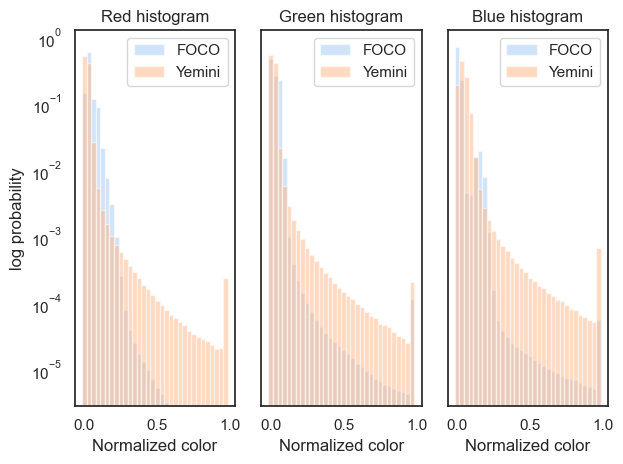

In [29]:
def plot_histograms(dataset_rgbs, labels):

    sns.set(style="white")
    fig, axs = plt.subplots(1,3, sharey=True)

    # Plot the bars using Matplotlib

    bin_edges = np.arange(32)/32

    for i, ax in enumerate(axs):
        #ax.hist(im_flat[:,i], bins= np.arange(32)/32, color= 'red')
        for j, dataset in enumerate(dataset_rgbs):
            ax.bar(bin_edges[:], dataset[:,i], alpha=0.5, align='center', width=1/32, color=sns.color_palette("pastel")[j], log=True, label=labels[j])
            #ax.bar(bin_edges[:], yem_rgb[:,0], alpha=0.5, align='center', width=1/32, color=sns.color_palette("pastel")[1], log=True, label='Yemini')
        ax.legend()
        #sns.histplot(ax=ax, data=np.ones(32),weights=np.transpose(foco_rgb[:,i]), bins= np.arange(32)/32, alpha=0.3, stat = 'probability', log_scale=(False,True), label='FOCO')
        #sns.histplot(ax=ax, data=np.ones(32),weights=np.transpose(yem_rgb[:,i]), bins=np.arange(32)/32, alpha=0.3, stat = 'probability',log_scale=(False,True), label='Yemini')

    axs[0].set_title('Red histogram')
    axs[0].set_xlabel('Normalized color')
    axs[0].set_ylabel('log probability')
    axs[1].set_title('Green histogram')
    axs[1].set_xlabel('Normalized color')
    axs[2].set_title('Blue histogram')
    axs[2].set_xlabel('Normalized color')

    plt.tight_layout()
    plt.show()

plot_histograms([foco_rgb, yem_rgb], ['FOCO', 'Yemini'])

In [30]:
color_discrim_FOCO = get_color_discrim('/Users/danielysprague/foco_lab/data/NWB_Ray', 6)
color_discrim_Yemini = get_color_discrim('/Users/danielysprague/foco_lab/data/Yemini_NWB', 6)


20230412-20-15-17.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230506-14-24-57.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230510-13-25-46.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230322-22-43-03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20221106-21-47-31.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230506-12-56-00.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20221106-21-00-09.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230322-20-16-50.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20221028-18-48-00.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230506-13-32-08.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230510-16-36-46.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230506-15-33-51.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230510-15-49-47.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20221215-20-02-49.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230322-21-41-10.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20221106-21-23-19.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230506-15-01-45.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230510-12-53-34.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20221215-22-02-55.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230322-18-57-04.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_08.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190929_02.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190929_03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190925_01.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20191030_07.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190925_04.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20191030_03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190929_05.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190929_07.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190929_06.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20191104_10.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20191104_08.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190924_01.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_01.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190924_03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190924_02.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_13.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_07.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_11.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_05.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [64]:
color_discrim_FOCO_og = get_color_discrim('/Users/danielysprague/foco_lab/data/NWB_foco', 6)
color_discrim_NP = get_color_discrim('/Users/danielysprague/foco_lab/data/NP_nwb', 6)

2021-12-03-w00-NP1.nwb
2022-03-05-w00-NP1.nwb
2022-02-12-w00-NP1.nwb
2022-02-22-w04-NP1.nwb
2022-02-11-w03-NP1.nwb
2022-02-12-w01-NP1.nwb
2022-01-22-w04-NP1.nwb
2022-04-26-w01-NP1.nwb
2022-04-26-w00-NP1.nwb
2022-04-01-w00-NP1.nwb
56_YAaDV.nwb
38_YAaDV.nwb
76_YAaDV.nwb
11_YAaLR.nwb
64_YAaDV.nwb
70_YAaLR.nwb
55_YAaDV.nwb
7_YAaLR.nwb
62_YAaLR.nwb
20_YAaLR.nwb


In [73]:
df = pd.DataFrame({'avg_col_discrim': 5.3, 'identifier':'asdf'})

print(df)


ValueError: If using all scalar values, you must pass an index

In [78]:
color_df = pd.DataFrame(columns=['avg_col_discrim', 'identifier'])

datasets= [color_discrim_FOCO, color_discrim_Yemini, color_discrim_FOCO_og, color_discrim_NP]

for dataset in datasets:
    for key, value in dataset.items():
        color_df = pd.concat([color_df, pd.DataFrame({'avg_col_discrim': np.mean(value), 'identifier':key[:-4]}, index=[0])], ignore_index=True)

print(color_df)

    avg_col_discrim         identifier
0          0.233278  20230412-20-15-17
1          0.182110  20230506-14-24-57
2          0.275786  20230510-13-25-46
3          0.145156  20230322-22-43-03
4          0.163429  20221106-21-47-31
..              ...                ...
56         1.837451           70_YAaLR
57         2.101219           55_YAaDV
58         1.792815            7_YAaLR
59         1.785512           62_YAaLR
60         2.016502           20_YAaLR

[61 rows x 2 columns]


In [65]:
plot_color_discrim([color_discrim_FOCO, color_discrim_Yemini, color_discrim_FOCO_og, color_discrim_NP], ['FOCO', 'Yemini', 'FOCO_og', 'NP'])

/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


## Figure 4: Benchmarking performance of consolidated datasets 

All experiments run using consolidated dataset, different image processing approaches, box-whisker plot similar to above

In [32]:
atlas_df = atlas.get_df()
atlas_df

gt = pd.read_csv('/Users/danielysprague/foco_lab/data/NP_paper/all/11_YAaLR.csv', skiprows=7)
gt = gt.rename(columns={'User ID':'ID'})
autID = pd.read_csv('/Users/danielysprague/foco_lab/data/Yemini_paper_results/11_YAaLR.csv')

merged_df = pd.merge(gt, atlas_df[['ID', 'neuron_class']], on='ID', how='left')

merged_df.head()

,ID,User Confidence,Emphasized?,Auto ID,Auto Confidence,Unnamed: 5,Real X (um),Real Y (um),Real Z (um),Unnamed: 9,Z-Scored Red,Z-Scored Green,Z-Scored Blue,Z-Scored White,Unnamed: 14,Estimated GFP,Max GFP,Normalized GFP,Unnamed: 18,neuron_class
0,I1R,1.0,0,NaN,NaN,NaN,18.336782,20.794996,15.750000,NaN,6.044556,7.954885,10.833543,12.396418,NaN,21554.384615,22530.0,1738.759089,NaN,I1
1,I1L,1.0,0,NaN,NaN,NaN,21.379345,20.341513,21.750000,NaN,9.740729,18.229802,18.862395,12.439850,NaN,19731.692308,21061.0,1586.167972,NaN,I1
2,AMSOL,1.0,0,NaN,NaN,NaN,24.907975,9.963190,24.750000,NaN,2.982248,14.802994,0.359120,9.707879,NaN,20621.846154,21386.0,2124.238120,NaN,AMSO
3,I2R,1.0,0,NaN,NaN,NaN,33.666744,24.509281,11.683901,NaN,12.925403,2.693210,3.037950,12.439850,NaN,18596.692308,19243.0,1494.928932,NaN,I2
4,I2L,1.0,0,NaN,NaN,NaN,33.956429,22.916969,24.353949,NaN,17.382137,3.397190,7.285318,12.439850,NaN,20084.538462,20771.0,1614.532151,NaN,I2


In [34]:
gt = pd.read_csv('/Users/danielysprague/foco_lab/data/NP_paper/all/70_YApLR.csv', skiprows=7)
gt = gt.rename(columns={'User ID':'ID'})
autID = pd.read_csv('/Users/danielysprague/foco_lab/data/Yemini_paper_results/70_YApLR.csv')

IDd, per_ID, accs = get_accuracy(gt, autID, LR=True, atlas=atlas)
print(accs)

[0.0, 0.0, 0.0, 0.0]


38_YAaDV.csv
0.9081632653061225
56_YAaDV.csv
0.8928571428571429
64_YAaDV.csv
0.8958333333333334
11_YAaLR.csv
0.8969072164948454
76_YAaDV.csv
0.9067357512953368
20_YAaLR.csv
0.8298969072164949
62_YAaLR.csv
0.38095238095238093
7_YAaLR.csv
0.8802083333333334
55_YAaDV.csv
0.953125
70_YAaLR.csv
0.9481865284974094


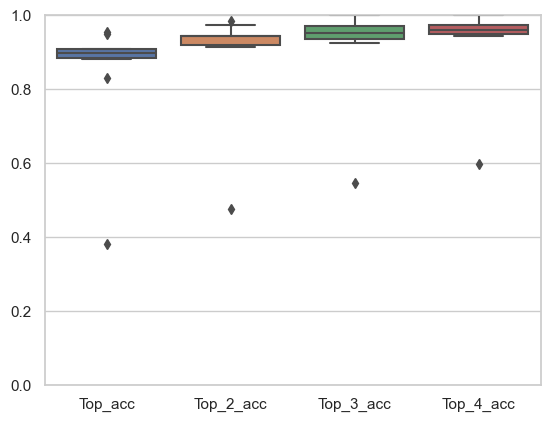

In [35]:
def plot_accuracy_paper(folder,atlas):

    all_accs = None

    for file in os.listdir(folder):

        if file[-4:]=='.csv' and file[-7]=='a':
            gt = pd.read_csv(folder+'/'+file, skiprows=7)
            gt = gt.rename(columns={'User ID':'ID'})
            autID = pd.read_csv('/Users/danielysprague/foco_lab/data/Yemini_paper_results/'+file)

            IDd, per_ID, accs = get_accuracy(gt, autID, LR=True, atlas=atlas)

            print(file)
            print(accs[0])

            if all_accs is None:
                all_accs = np.asarray(accs)

            else:
                all_accs = np.vstack((all_accs, accs))

        else:
            continue

    df = pd.DataFrame(all_accs, columns=['Top_acc', 'Top_2_acc', 'Top_3_acc', 'Top_4_acc'])

    sns.boxplot(data=df, orient='v')

    plt.ylim((0,1))

    plt.show()

    return df


df = plot_accuracy_paper('/Users/danielysprague/foco_lab/data/NP_paper/all', atlas)

In [49]:
old_FOCO_dataset = get_dataset_neurons('/Users/danielysprague/foco_lab/data/NWB_foco')

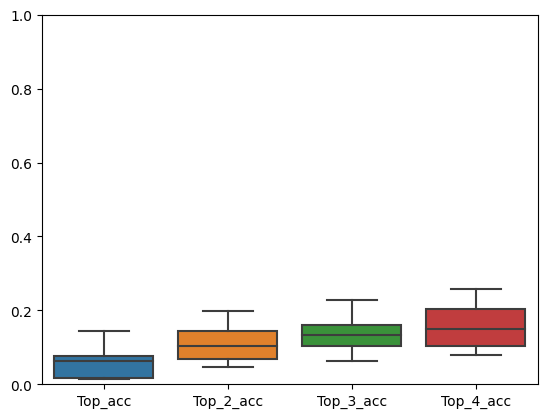

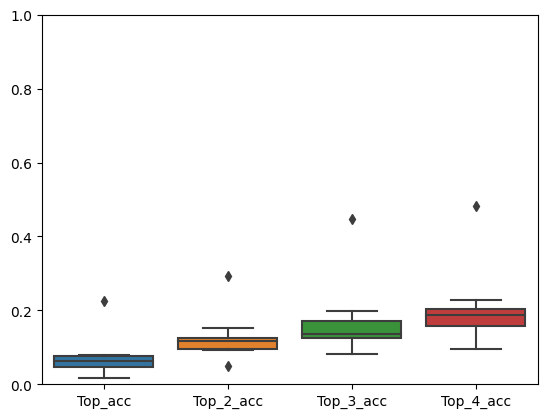

In [56]:
%matplotlib inline

def plot_accuracy(dataset, csv_folder, atlas):

    all_accs = np.zeros((len(dataset), 4))

    for i, key in enumerate(dataset.keys()):
        csv_nwb = csv_folder+key+'.csv'
        IDd, per_ID, accs = get_accuracy(dataset[key], pd.read_csv(csv_nwb), LR=True, atlas=atlas)

        all_accs[i,:4] = np.transpose(np.asarray(accs))

    df = pd.DataFrame(all_accs, columns=['Top_acc', 'Top_2_acc', 'Top_3_acc', 'Top_4_acc'])

    sns.boxplot(data=df, orient='v')

    plt.ylim((0,1))

    plt.show()

    return df



df = plot_accuracy(chaud_dataset, '/Users/danielysprague/foco_lab/data/NWB_chaudhary_results_match/', atlas)
df = plot_accuracy(chaud_dataset, '/Users/danielysprague/foco_lab/data/NWB_chaudhary_results/', atlas)

    
        

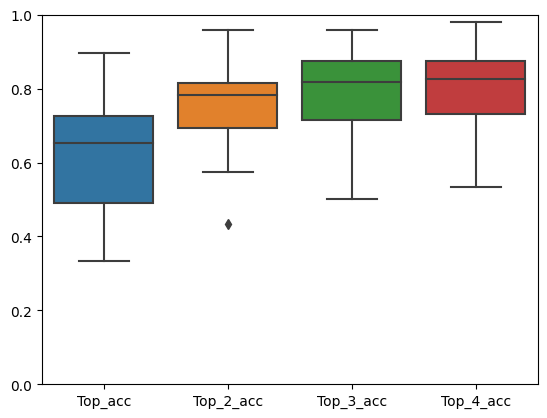

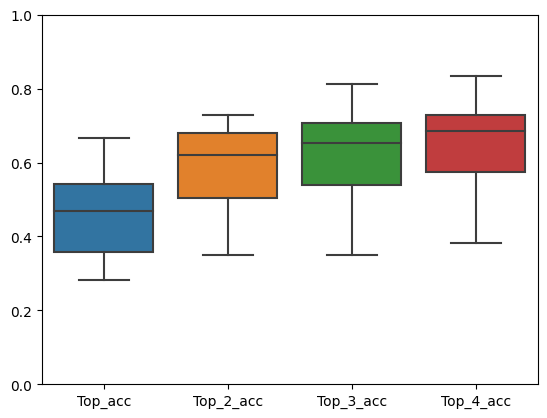

In [57]:
df = plot_accuracy(old_FOCO_dataset, '/Users/danielysprague/foco_lab/data/NWB_foco_results_match/', atlas)
df = plot_accuracy(old_FOCO_dataset, '/Users/danielysprague/foco_lab/data/NWB_foco_results/', atlas)

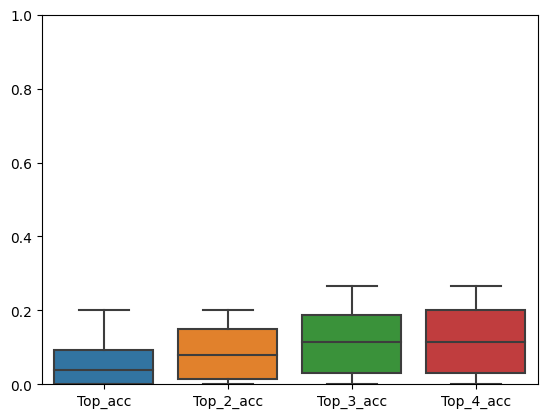

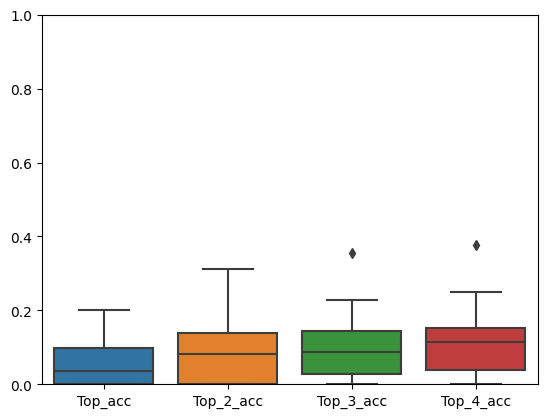

In [58]:
df = plot_accuracy(FOCO_dataset, '/Users/danielysprague/foco_lab/data/NWB_Ray_results_match/', atlas)
df = plot_accuracy(FOCO_dataset, '/Users/danielysprague/foco_lab/data/NWB_Ray_results/', atlas)

In [69]:
%matplotlib qt
acc_df = plot_accuracies([NP_dataset, Yem_dataset, FOCO_dataset, old_FOCO_dataset, chaud_dataset], ['/Users/danielysprague/foco_lab/data/NP_nwb_results/','/Users/danielysprague/foco_lab/data/Yemini_NWB_results/', '/Users/danielysprague/foco_lab/data/NWB_Ray_results/', '/Users/danielysprague/foco_lab/data/NWB_foco_results/', '/Users/danielysprague/foco_lab/data/NWB_chaudhary_results/'], ['NP','Yemini', 'FOCO', 'FOCO_old', 'chaudhary'], LR=True, atlas=atlas)
acc_df = plot_accuracies([NP_dataset, Yem_dataset, FOCO_dataset, old_FOCO_dataset, chaud_dataset], ['/Users/danielysprague/foco_lab/data/NP_nwb_results/','/Users/danielysprague/foco_lab/data/Yemini_NWB_results_match/', '/Users/danielysprague/foco_lab/data/NWB_Ray_results_match/', '/Users/danielysprague/foco_lab/data/NWB_foco_results_match/', '/Users/danielysprague/foco_lab/data/NWB_chaudhary_results_match/'], ['NP','Yemini', 'FOCO', 'FOCO_old', 'chaudhary'], LR=True, atlas=atlas)
acc_matched_df = plot_accuracies([NP_dataset, Yem_dataset, FOCO_dataset, old_FOCO_dataset, chaud_dataset], ['/Users/danielysprague/foco_lab/data/NP_nwb_results/','/Users/danielysprague/foco_lab/data/Yemini_NWB_results_match_new/', '/Users/danielysprague/foco_lab/data/NWB_Ray_results_match_new/', '/Users/danielysprague/foco_lab/data/NWB_foco_results_match_new/', '/Users/danielysprague/foco_lab/data/NWB_chaudhary_results_match_new/'], ['NP','Yemini', 'FOCO', 'FOCO_old', 'chaudhary'], LR=True, atlas=atlas)
    

/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


In [60]:
acc_df

,top_acc,top_2_acc,top_3_acc,top_4_acc,dataset,identifier
0,0.910995,0.947644,0.958115,0.968586,NP,56_YAaDV
1,0.905263,0.978947,0.984211,0.984211,NP,38_YAaDV
2,0.920213,0.962766,0.973404,0.978723,NP,76_YAaDV
3,0.896373,0.958549,0.974093,0.989637,NP,11_YAaLR
4,0.878307,0.957672,0.962963,0.973545,NP,64_YAaDV
...,...,...,...,...,...,...
56,0.365079,0.52381,0.634921,0.666667,FOCO_old,2022-02-12-w01-NP1
57,0.6875,0.8125,0.854167,0.854167,FOCO_old,2022-01-22-w04-NP1
58,0.6,0.7,0.725,0.725,FOCO_old,2022-04-26-w01-NP1
59,0.5,0.657895,0.736842,0.789474,FOCO_old,2022-04-26-w00-NP1


In [380]:
acc_df.to_csv('/Users/danielysprague/foco_lab/data/acc_results.csv')

In [83]:
def get_accuracies_newatlas(folder, atlas):
    accs = {}
    for file in os.listdir(folder):
        filename = file[:-4]
        if not file[-4:] == '.csv':
            continue

        df_data = pd.read_csv(folder + '/'+file)
        df_data = df_data.rename(columns={"aligned_x":"X","aligned_y":"Y","aligned_z":"Z", "aligned_R":"R", "aligned_G":"G", "aligned_B":"B"})

        per_ID, per_corr, df_assigns = run_linear_assignment(df_data, atlas)

        accs[filename] = per_corr
    
    return accs

accs_NP = get_accuracies_newatlas('/Users/danielysprague/foco_lab/data/aligned_NP', NP_atlas)
accs_full = get_accuracies_newatlas('/Users/danielysprague/foco_lab/data/aligned_full', NWB_atlas)

In [91]:
def plot_accuracies_newatlas(datasets, accs_NP, accs_full, labels):

    df = pd.DataFrame(columns=['acc_NP','acc_full', 'dataset'])

    for i, dataset in enumerate(datasets):
        for key in dataset.keys():
            acc_NP = accs_NP[key]
            acc_full = accs_full[key]

            df.loc[len(df.index)] = [acc_NP, acc_full, labels[i]]

    fig, axs = plt.subplots(1,2)

    sns.boxplot(ax= axs[0], data = df, x = 'dataset', y='acc_NP', hue='dataset', orient='v',dodge=False) 
    sns.boxplot(ax= axs[1], data = df, x = 'dataset', y='acc_full', hue='dataset', orient='v',dodge=False) 
    sns.scatterplot(ax= axs[0], data = df, x = 'dataset', y='acc_NP', hue='dataset') 
    sns.scatterplot(ax= axs[1], data = df, x = 'dataset', y='acc_full', hue='dataset') 
    axs[0].set_ylim((0,1))
    axs[1].set_ylim((0,1))
    
    for ax in axs:
        ax.legend([],[], frameon=False)
    
plot_accuracies_newatlas([NP_dataset, chaud_dataset, Yem_dataset, old_FOCO_dataset, FOCO_dataset], accs_NP, accs_full, ['NP', 'Chaudhary', 'Yemini', 'Old FOCO', 'New FOCO'])

-8.681597328887555
1.1349352314164558e-12


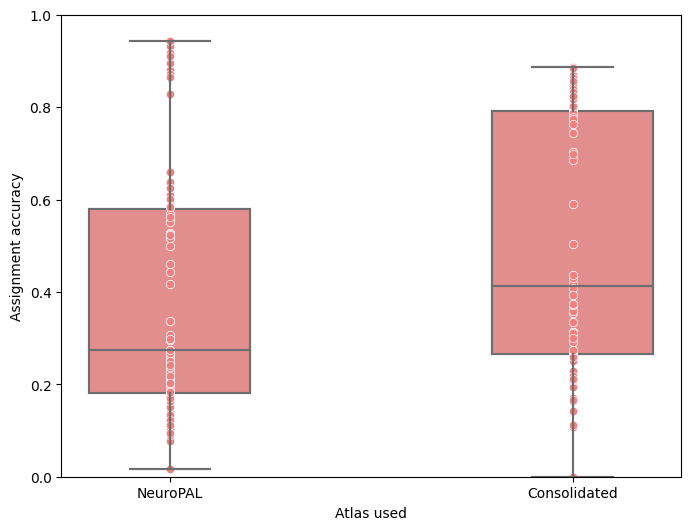

In [108]:
%matplotlib inline
import scipy.stats as stats

def plot_accuracies_atlas_compare(datasets, accs_NP, accs_full):

    df = pd.DataFrame(columns=['NeuroPAL','Consolidated', 'dataset'])

    for i, dataset in enumerate(datasets):
        for key in dataset.keys():
            acc_NP = accs_NP[key]
            acc_full = accs_full[key]

            df.loc[len(df.index)] = [acc_NP, acc_full, key]
    
    df_long = pd.melt(df, id_vars='dataset', value_vars=['NeuroPAL', 'Consolidated'], var_name='Accuracy', value_name='Value')

    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Accuracy', y='Value', data=df_long, color='skyblue', width=0.4)
    sns.boxplot(x='Accuracy', y='Value', data=df_long, color='lightcoral', width=0.4)
    sns.scatterplot(x='Accuracy', y='Value', data=df_long, color='skyblue')
    sns.scatterplot(x='Accuracy', y='Value', data=df_long, color='lightcoral')

    t, prob = stats.ttest_rel(np.asarray(df['NeuroPAL']), np.asarray(df['Consolidated']))

    plt.ylabel('Assignment accuracy')
    plt.xlabel('Atlas used')
    plt.ylim((0,1))

    print(t)
    print(prob)
    # Add lines connecting data points from the same dataset
    #for i in range(len(df)):
    #    plt.plot([i, i], [df['acc_NP'][i], df['acc_full'][i]], color='gray', linestyle='-', linewidth=1, alpha=0.7)

    plt.show()

plot_accuracies_atlas_compare([NP_dataset, chaud_dataset, Yem_dataset, old_FOCO_dataset, FOCO_dataset], accs_NP, accs_full)

In [109]:
print(accs_NP)
print(accs_full)

{'6': 0.336283185840708, '7': 0.27350427350427353, '20221106-21-00-09': 0.10344827586206896, '20230322-20-16-50': 0.11382113821138211, '5': 0.25203252032520324, '4': 0.29508196721311475, '2021-12-03-w00-NP1': 0.2558139534883721, '20221106-21-47-31': 0.16379310344827586, '20230322-22-43-03': 0.13445378151260504, '20230506-12-56-00': 0.2376237623762376, '20230506-14-24-57': 0.2980769230769231, '1': 0.18584070796460178, '38_YAaDV': 0.9333333333333333, '20230510-13-25-46': 0.15178571428571427, '20230412-20-15-17': 0.10752688172043011, '56_YAaDV': 0.8717948717948718, '20190928_08': 0.5683060109289617, '3': 0.1794871794871795, '2': 0.19834710743801653, '20191104_10': 0.5172413793103449, '20190929_06': 0.5168539325842697, '64_YAaDV': 0.8958333333333334, '20190929_07': 0.5988700564971752, '20230510-16-36-46': 0.12195121951219512, '20191030_03': 0.6378378378378379, '20190929_05': 0.4176470588235294, '2022-03-05-w00-NP1': 0.17857142857142858, '20190925_04': 0.6101694915254238, '11_YAaLR': 0.8711

In [80]:
datasets = [NP_dataset, chaud_dataset, Yem_dataset, old_FOCO_dataset, FOCO_dataset]
names = ['NP', 'Chaudhary', 'Yemini', 'Old FOCO', 'New FOCO']
for i, dataset in enumerate(datasets):
    print(names[i])
    print(len(dataset.keys()))


NP
10
Chaudhary
9
Yemini
21
Old FOCO
10
New FOCO
20


In [82]:
print(accs_NP)
print(accs_full)

[0.336283185840708, 0.27350427350427353, 0.10344827586206896, 0.11382113821138211, 0.25203252032520324, 0.29508196721311475, 0.2558139534883721, 0.16379310344827586, 0.13445378151260504, 0.2376237623762376, 0.2980769230769231, 0.18584070796460178, 0.9333333333333333, 0.15178571428571427, 0.10752688172043011, 0.8717948717948718, 0.5683060109289617, 0.1794871794871795, 0.19834710743801653, 0.5172413793103449, 0.5168539325842697, 0.8958333333333334, 0.5988700564971752, 0.12195121951219512, 0.6378378378378379, 0.4176470588235294, 0.17857142857142858, 0.6101694915254238, 0.8711340206185567, 0.8808290155440415, 0.46111111111111114, 0.5271739130434783, 0.07692307692307693, 0.4438202247191011, 0.3072289156626506, 0.16981132075471697, 0.25139664804469275, 0.2748091603053435, 0.21428571428571427, 0.11214953271028037, 0.20689655172413793, 0.659217877094972, 0.26857142857142857, 0.24271844660194175, 0.18333333333333332, 0.8290155440414507, 0.1746987951807229, 0.5232558139534884, 0.6243093922651933

In [77]:
def plot_accuracies(datasets, csv_folders, labels, LR=False, atlas=None, title = 'Accuracy by dataset'):

    num_data_total = np.sum([len(dataset.keys()) for dataset in datasets])

    accs = np.empty((num_data_total, 6), dtype='O')

    k=0

    for i, dataset in enumerate(datasets):
        csv_folder = csv_folders[i]
        label = labels[i]
        for j, key in enumerate(dataset.keys()):
            csv = csv_folder + key +'.csv'
            IDd, per_ID, acc = get_accuracy(dataset[key], pd.read_csv(csv), LR=LR, atlas=atlas)
            acc.append(label)
            acc.append(key)
            accs[k,:] = acc
            k+=1

    df = pd.DataFrame(accs, columns = ['top_acc', 'top_2_acc', 'top_3_acc', 'top_4_acc', 'dataset', 'identifier'])

    sns.boxplot(data=df, x = 'dataset', y='top_acc', hue='dataset', orient='v', dodge=False)

    plt.ylabel('Percent autoID accuracy')
    plt.ylim((0,1))

    plt.title('NeuroPAL AutoID accuracy by dataset')

    plt.show()

    return df

acc_df = plot_accuracies([NP_dataset, Yem_dataset, FOCO_dataset, old_FOCO_dataset, chaud_dataset], ['/Users/danielysprague/foco_lab/data/NP_nwb_results/','/Users/danielysprague/foco_lab/data/Yemini_NWB_results_match/', '/Users/danielysprague/foco_lab/data/NWB_Ray_results_match/', '/Users/danielysprague/foco_lab/data/NWB_foco_results_match/','/Users/danielysprague/foco_lab/data/NWB_chaudhary_results_match/'], ['NP','Yemini', 'FOCO', 'FOCO_old', 'Chaudhary'], LR=True, atlas=atlas)

    

In [77]:
color_df

,avg_col_discrim,identifier
0,0.233278,20230412-20-15-17.nwb
1,0.182110,20230506-14-24-57.nwb
2,0.275786,20230510-13-25-46.nwb
3,0.145156,20230322-22-43-03.nwb
4,0.163429,20221106-21-47-31.nwb
...,...,...
56,1.837451,70_YAaLR.nwb
57,2.101219,55_YAaDV.nwb
58,1.792815,7_YAaLR.nwb
59,1.785512,62_YAaLR.nwb


In [79]:
color_acc = acc_df.merge(color_df, on='identifier')

In [80]:
color_acc

,top_acc,top_2_acc,top_3_acc,top_4_acc,dataset,identifier,avg_col_discrim
0,0.910995,0.947644,0.958115,0.968586,NP,56_YAaDV,1.807562
1,0.905263,0.978947,0.984211,0.984211,NP,38_YAaDV,1.991833
2,0.920213,0.962766,0.973404,0.978723,NP,76_YAaDV,1.799838
3,0.896373,0.958549,0.974093,0.989637,NP,11_YAaLR,1.905245
4,0.878307,0.957672,0.962963,0.973545,NP,64_YAaDV,2.160154
...,...,...,...,...,...,...,...
56,0.365079,0.52381,0.634921,0.666667,FOCO_old,2022-02-12-w01-NP1,0.468498
57,0.6875,0.8125,0.854167,0.854167,FOCO_old,2022-01-22-w04-NP1,0.307903
58,0.6,0.7,0.725,0.725,FOCO_old,2022-04-26-w01-NP1,0.267753
59,0.5,0.657895,0.736842,0.789474,FOCO_old,2022-04-26-w00-NP1,0.569796


## Figure 5: Atlas visualizations - projected color space visualization, unrollled butterfly visualization